In [1]:
# =========================
# 0) Configuration
# =========================
# Fixed dataset path and target handling
DATA_PATH = "./data_motobikes.xlsx"
TARGET_COL = "price"

# Optional: use log1p(target)
USE_LOG_TARGET = False

# Warnings & libs
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1) Load Dataset
Reads **`data_motobikes.xlsx`** using `openpyxl`.


In [2]:
# =========================
# 1) Load Dataset
# =========================
import pandas as pd

df = pd.read_excel(DATA_PATH, engine="openpyxl")

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Dtypes:\n", df.dtypes)

if df.empty:
    raise ValueError("Loaded dataset is empty. Please check the file content.")


Shape: (7208, 18)
Columns: ['id', 'Tiêu đề', 'Giá', 'Khoảng giá min', 'Khoảng giá max', 'Địa chỉ', 'Mô tả chi tiết', 'Thương hiệu', 'Dòng xe', 'Năm đăng ký', 'Số Km đã đi', 'Tình trạng', 'Loại xe', 'Dung tích xe', 'Xuất xứ', 'Chính sách bảo hành', 'Trọng lượng', 'Href']
Dtypes:
 id                      int64
Tiêu đề                object
Giá                    object
Khoảng giá min         object
Khoảng giá max         object
Địa chỉ                object
Mô tả chi tiết         object
Thương hiệu            object
Dòng xe                object
Năm đăng ký            object
Số Km đã đi             int64
Tình trạng             object
Loại xe                object
Dung tích xe           object
Xuất xứ                object
Chính sách bảo hành    object
Trọng lượng            object
Href                   object
dtype: object


### Xử lý data và review lại data

In [3]:
# Xử lý cột 'Giá': Bỏ ' đ', loại dấu '.', chuyển thành float
def clean_price(x):
    if isinstance(x, str):  # Kiểm tra nếu là chuỗi
        x = x.replace('.', '').replace(' đ', '').strip()
        try:
            return float(x)
        except ValueError:
            return np.nan
    return x

# Xử lý cột 'Khoảng giá min' và 'Khoảng giá max': Chuyển '72.53 tr' -> 72530000 (giả sử 'tr' = triệu)
def clean_range(x):
    if isinstance(x, str):
        x = x.replace(' tr', '').replace(',', '.').strip()  # Bỏ ' tr', thay ',' thành '.' để float
        try:
            return float(x) * 1000000
        except ValueError:
            return np.nan
    return x

df['Giá'] = df['Giá'].apply(clean_price)
df['Khoảng giá min'] = df['Khoảng giá min'].apply(clean_range)
df['Khoảng giá max'] = df['Khoảng giá max'].apply(clean_range)

# Xử lý cột 'Năm đăng ký': Nếu 'trước năm 1980' thì thành 1980, chuyển thành int
def clean_year(x):
    if isinstance(x, str) and 'trước năm 1980' in x.lower():
        return 1980
    try:
        return int(x)
    except ValueError:
        return np.nan

df['Năm đăng ký'] = df['Năm đăng ký'].apply(clean_year)


In [4]:
# Xem kích thước và vài dòng đầu
print(df.shape)
df.head()

# Kiểm tra kiểu dữ liệu và giá trị null
df.info()

# Kiểm tra giá trị thiếu theo cột
df.isnull().sum()

# Thống kê đầy đủ cho tất cả cột (bao gồm categorical)
print("\nThống kê describe cho tất cả cột:")
display(df.describe(include='all'))

(7208, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7208 entries, 0 to 7207
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   7208 non-null   int64  
 1   Tiêu đề              7207 non-null   object 
 2   Giá                  7206 non-null   float64
 3   Khoảng giá min       7006 non-null   float64
 4   Khoảng giá max       7011 non-null   float64
 5   Địa chỉ              7167 non-null   object 
 6   Mô tả chi tiết       7208 non-null   object 
 7   Thương hiệu          7205 non-null   object 
 8   Dòng xe              7205 non-null   object 
 9   Năm đăng ký          7208 non-null   int64  
 10  Số Km đã đi          7208 non-null   int64  
 11  Tình trạng           7208 non-null   object 
 12  Loại xe              7208 non-null   object 
 13  Dung tích xe         7208 non-null   object 
 14  Xuất xứ              7208 non-null   object 
 15  Chính sách bảo hành  7207 n

,id,Tiêu đề,Giá,Khoảng giá min,Khoảng giá max,Địa chỉ,Mô tả chi tiết,Thương hiệu,Dòng xe,Năm đăng ký,Số Km đã đi,Tình trạng,Loại xe,Dung tích xe,Xuất xứ,Chính sách bảo hành,Trọng lượng,Href
count,7208.000000,7207,7.206000e+03,7.006000e+03,7.011000e+03,7167,7208,7205,7205,7208.000000,7208.000000,7208,7208,7208,7208,7207,7207,7208
unique,NaN,6839,NaN,NaN,NaN,310,7183,37,195,NaN,NaN,2,3,7,12,1,1,7196
top,NaN,Bán xe,NaN,NaN,NaN,"Phường Bình Hưng Hoà A, Quận Bình Tân, Tp Hồ C...",Mình cần bán xe như hình \nXe giấy tờ đầy đủ n...,Honda,Wave,NaN,NaN,Đã sử dụng,Tay ga,100 - 175 cc,Việt Nam,Bảo hành hãng,> 50 kg,https://xe.chotot.com/mua-ban-xe-may-huyen-nha...
freq,NaN,29,NaN,NaN,NaN,113,10,4374,727,NaN,NaN,7207,3600,5857,2875,7207,7207,3
mean,3604.500000,NaN,4.924194e+07,2.390171e+07,2.805974e+07,NaN,NaN,NaN,NaN,2013.721143,64378.889012,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,2080.914703,NaN,1.603077e+09,2.992946e+07,3.512554e+07,NaN,NaN,NaN,NaN,7.865770,136573.455355,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,0.000000e+00,1.230000e+06,1.440000e+06,NaN,NaN,NaN,NaN,1980.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,1802.750000,NaN,8.500000e+06,7.980000e+06,9.370000e+06,NaN,NaN,NaN,NaN,2010.000000,10000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,3604.500000,NaN,1.650000e+07,1.453000e+07,1.705000e+07,NaN,NaN,NaN,NaN,2015.000000,28000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,5406.250000,NaN,3.250000e+07,2.832000e+07,3.325000e+07,NaN,NaN,NaN,NaN,2019.000000,53327.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2) Quick EDA & Robust Target Detection
Summaries, missingness, unique counts, column typing, and auto target detection.



,id,Tiêu đề,Giá,Khoảng giá min,Khoảng giá max,Địa chỉ,Mô tả chi tiết,Thương hiệu,Dòng xe,Năm đăng ký,Số Km đã đi,Tình trạng,Loại xe,Dung tích xe,Xuất xứ,Chính sách bảo hành,Trọng lượng,Href
0,1,"Bán Vespa Sprint 125cc 2024 xanh dương, xe đẹp...",66000000.0,72530000.0,85140000.0,"Phường Bến Thành, Quận 1, Tp Hồ Chí Minh",Bán xe #Vespa Sprint 125cc. Mua mới tại #Topco...,Piaggio,Vespa,2024,14000,Đã sử dụng,Tay ga,100 - 175 cc,Đang cập nhật,Bảo hành hãng,> 50 kg,https://xe.chotot.com/mua-ban-xe-may-quan-1-tp...
1,2,🔥🔥SH 150i Thắng ABS 2019 BSTP Chính Chủ,79500000.0,62760000.0,73680000.0,"Phường Tân Định, Quận 1, Tp Hồ Chí Minh","_Bán SH 150i Thắng ABS 2019 Xám Bạc, Úp Team X...",Honda,SH,2019,28000,Đã sử dụng,Tay ga,100 - 175 cc,Đang cập nhật,Bảo hành hãng,> 50 kg,https://xe.chotot.com/mua-ban-xe-may-quan-1-tp...
2,3,CC Vision Thể Thao 2023 Đen+bộ đèn Demi audi A7,37000000.0,28000000.0,32860000.0,"Phường Cầu Kho, Quận 1, Tp Hồ Chí Minh",Chính chủ bán Vision phiên bản Thể Thao 2023 Đ...,Honda,Vision,2023,12000,Đã sử dụng,Tay ga,100 - 175 cc,Đang cập nhật,Bảo hành hãng,> 50 kg,https://xe.chotot.com/mua-ban-xe-may-quan-1-tp...
3,4,Vespa Sprint 2019 -125- Đen Đỏ Sport -CHÍNH ...,45000000.0,43100000.0,50600000.0,"Phường Bến Nghé, Quận 1, Tp Hồ Chí Minh",XE CÁ NHÂN BÁN - XE DO EM ĐỨNG TÊN CHÍNH C...,Piaggio,Vespa,2019,60000,Đã sử dụng,Tay ga,100 - 175 cc,Đang cập nhật,Bảo hành hãng,> 50 kg,https://xe.chotot.com/mua-ban-xe-may-quan-1-tp...
4,5,Xe tay ga Yamaha Latte 125 – Đăng ký 2021,23000000.0,17020000.0,19980000.0,"Phường Tân Định, Quận 1, Tp Hồ Chí Minh",🛵 Thông tin xe:\n\nDòng xe tay ga cao cấp Yama...,Yamaha,Latte,2021,24000,Đã sử dụng,Tay ga,100 - 175 cc,Nhật Bản,Bảo hành hãng,> 50 kg,https://xe.chotot.com/mua-ban-xe-may-quan-1-tp...


Rows: 7208
Columns: 18

Missing values per column:
 Khoảng giá min         202
Khoảng giá max         197
Địa chỉ                 41
Thương hiệu              3
Dòng xe                  3
Giá                      2
Chính sách bảo hành      1
Tiêu đề                  1
Trọng lượng              1
id                       0
Năm đăng ký              0
Mô tả chi tiết           0
Số Km đã đi              0
Tình trạng               0
Dung tích xe             0
Loại xe                  0
Xuất xứ                  0
Href                     0
dtype: int64

Unique counts per column:
 id                     7208
Href                   7196
Mô tả chi tiết         7183
Tiêu đề                6840
Khoảng giá max         1349
Số Km đã đi            1323
Khoảng giá min         1305
Giá                     742
Địa chỉ                 311
Dòng xe                 196
Năm đăng ký              45
Thương hiệu              38
Xuất xứ                  12
Dung tích xe              7
Loại xe                   3
T

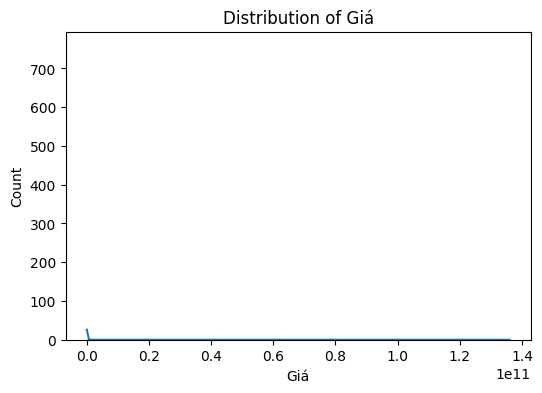

In [5]:
# =========================
# 2) Quick EDA & Robust Target Detection
# =========================
import re
import numpy as np
import pandas as pd

# Preview
try:
    display(df.head())
except Exception:
    print(df.head())
print("Rows:", len(df))
print("Columns:", len(df.columns))

# Missing values per column
missing = df.isna().sum().sort_values(ascending=False)
print("\nMissing values per column:\n", missing)

# Unique counts
unique_counts = df.nunique(dropna=False).sort_values(ascending=False)
print("\nUnique counts per column:\n", unique_counts)

# Infer categorical/numeric columns
cat_cols = [c for c in df.columns if df[c].dtype == 'object' or str(df[c].dtype).startswith('category')]
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
print("\nCategorical columns:", cat_cols)
print("Numeric columns:", num_cols)

# ---- Robust target detection ----
name_patterns = [
    r"price", r"amount", r"cost", r"fare", r"value", r"sales", r"revenue",
    r"target", r"label", r"response", r"y"
]

scores = {}
for c in df.columns:
    name_score = sum(bool(re.search(p, c, flags=re.IGNORECASE)) for p in name_patterns)
    type_score = 1 if pd.api.types.is_numeric_dtype(df[c]) else 0
    var_score = 0
    if pd.api.types.is_numeric_dtype(df[c]):
        try:
            var_score = float(np.nanvar(pd.to_numeric(df[c], errors='coerce')))
        except Exception:
            var_score = 0
    scores[c] = (name_score, type_score, var_score)

if (TARGET_COL is None) or (TARGET_COL not in df.columns):
    ranked = sorted(scores.items(), key=lambda kv: (kv[1][0], kv[1][1], kv[1][2]), reverse=True)
    if ranked:
        candidate, (ns, ts, vs) = ranked[0]
        if ns == 0 and ts == 0:
            numeric_only = [(c, s) for c, s in scores.items() if pd.api.types.is_numeric_dtype(df[c])]
            if numeric_only:
                candidate = max(numeric_only, key=lambda kv: kv[1][2])[0]
                print(f"WARNING: No typical target name found. Using highest-variance numeric column as target: {candidate}")
            else:
                print("ERROR: No numeric columns found. Please set TARGET_COL manually.")
                print("Available columns:", df.columns.tolist())
                raise KeyError("No suitable target column detected.")
        else:
            print(f"INFO: Target column auto-detected: {candidate} (name_score={ns}, numeric={bool(ts)})")
        TARGET_COL = candidate
    else:
        print("ERROR: Unable to rank columns. Please set TARGET_COL manually.")
        print("Available columns:", df.columns.tolist())
        raise KeyError("No suitable target column detected.")
else:
    print(f"INFO: Using provided TARGET_COL: {TARGET_COL}")

# Coerce target to numeric if possible
if not pd.api.types.is_numeric_dtype(df[TARGET_COL]):
    df[TARGET_COL] = pd.to_numeric(df[TARGET_COL], errors='coerce')
    if df[TARGET_COL].isna().all():
        print(f"ERROR: Target column '{TARGET_COL}' cannot be coerced to numeric.")
        raise TypeError("Target must be numeric for price prediction.")
    else:
        print(f"INFO: Coerced target '{TARGET_COL}' to numeric.")

print(f"\nTarget column: {TARGET_COL}")
print("Target missing count:", df[TARGET_COL].isna().sum())

# Target stats & distribution
print("Target stats:\n", df[TARGET_COL].describe())
plt.figure(figsize=(6,4))
sns.histplot(df[TARGET_COL].dropna(), kde=True)
plt.title(f"Distribution of {TARGET_COL}")
plt.show()


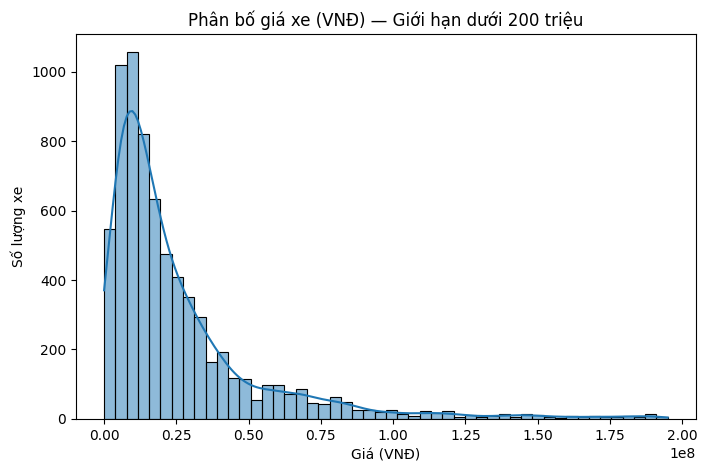

Thống kê mô tả giá:
count              7,206
mean          49,241,942
std        1,603,077,312
min                    0
25%            8,500,000
50%           16,500,000
75%           32,500,000
max      136,000,000,000
Name: Giá, dtype: object


In [6]:
#Phân tích 'Giá'
plt.figure(figsize=(8,5))
sns.histplot(df[df['Giá'] < 2e8]['Giá'], bins=50, kde=True)
plt.title("Phân bố giá xe (VNĐ) — Giới hạn dưới 200 triệu")
plt.xlabel("Giá (VNĐ)")
plt.ylabel("Số lượng xe")
plt.show()

print("Thống kê mô tả giá:")
print(df['Giá'].describe().apply(lambda x: format(x, ',.0f')))

## 3) Cleaning & Feature Engineering

### Xử lý outliner

In [7]:
# Sao chép dữ liệu tránh mất gốc
df_clean = df.copy()

# Quy tắc IQR cho cột "Giá"
Q1 = df_clean['Giá'].quantile(0.25)
Q3 = df_clean['Giá'].quantile(0.75)
IQR = Q3 - Q1

# Giữ lại những giá trong khoảng hợp lý
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Ngưỡng dưới: {lower_bound:,.0f} - Ngưỡng trên: {upper_bound:,.0f}")

df_clean = df_clean[(df_clean['Giá'] >= lower_bound) & (df_clean['Giá'] <= upper_bound)]
print(f"Số xe còn lại sau khi loại outlier: {len(df_clean)} / {len(df)}")


Ngưỡng dưới: -27,500,000 - Ngưỡng trên: 68,500,000
Số xe còn lại sau khi loại outlier: 6546 / 7208


In [8]:
# =========================
# 3) Cleaning & Feature Engineering
# =========================
import numpy as np
import pandas as pd


# Infer categorical/numeric
cat_cols = [c for c in df_clean.columns if df_clean[c].dtype == 'object' or str(df_clean[c].dtype).startswith('category')]
num_cols = [c for c in df_clean.columns if pd.api.types.is_numeric_dtype(df_clean[c])]

# Strip strings
for c in cat_cols:
    df_clean[c] = df_clean[c].astype(str).str.strip()

# Keep rows with target present and non-negative
df_clean = df_clean[df_clean[TARGET_COL].notna()]
if pd.api.types.is_numeric_dtype(df_clean[TARGET_COL]):
    df_clean = df_clean[df_clean[TARGET_COL] >= 0]

# Drop columns with extreme missingness (>95%)
missing_ratio = df_clean.isna().mean()
high_missing_cols = missing_ratio[missing_ratio > 0.95].index.tolist()
if high_missing_cols:
    print("Dropping high-missing columns:", high_missing_cols)
    df_clean = df_clean.drop(columns=high_missing_cols)
    cat_cols = [c for c in cat_cols if c not in high_missing_cols]
    num_cols = [c for c in num_cols if c not in high_missing_cols]

# log1p features for skewed numerics (excluding target)
skew = df_clean[num_cols].apply(lambda x: x.dropna().skew() if pd.api.types.is_numeric_dtype(x) else np.nan)
skewed = [c for c in skew[skew > 1].index.tolist() if c != TARGET_COL]
for c in skewed:
    df_clean[f"{c}_log1p"] = np.log1p(df_clean[c].clip(lower=0))
    num_cols.append(f"{c}_log1p")
print("Added log1p features:", skewed)

# Clip extreme outliers (1st–99th percentile) on numeric non-target
for c in list(num_cols):
    if c == TARGET_COL:
        continue
    if pd.api.types.is_numeric_dtype(df_clean[c]):
        lo, hi = df_clean[c].quantile([0.01, 0.99])
        df_clean[c] = df_clean[c].clip(lo, hi)

# Near-zero variance removal (numeric subset)
from sklearn.feature_selection import VarianceThreshold

feature_candidates = [c for c in df_clean.columns if c != TARGET_COL]
feature_candidates = [c for c in feature_candidates if (c in num_cols) or (c in cat_cols)]

X_preview = df_clean[feature_candidates].copy()
vt = VarianceThreshold(threshold=1e-5)
try:
    num_subset = [c for c in num_cols if c != TARGET_COL]
    if len(num_subset) > 0:
        vt.fit(X_preview[num_subset])
        nzv_keep_num_mask = vt.get_support()
        # *** v2 fix: keep Python strings, avoid numpy.str_ ***
        nzv_keep_num_cols = [num_subset[i] for i, keep in enumerate(nzv_keep_num_mask) if keep]
    else:
        nzv_keep_num_cols = []
except Exception as e:
    print("VarianceThreshold failed:", e)
    nzv_keep_num_cols = [c for c in num_cols if c != TARGET_COL]

selected_num_cols = nzv_keep_num_cols
selected_cat_cols = cat_cols

# *** v2 fix: enforce Python str types in feature name lists ***
selected_num_cols = [str(c) for c in selected_num_cols]
selected_cat_cols = [str(c) for c in selected_cat_cols]

print("Selected numeric features:", selected_num_cols)
print("Selected categorical features:", selected_cat_cols)

if df_clean.empty:
    raise ValueError("After cleaning, no rows remain. Please relax filters or check data quality.")


Added log1p features: ['Khoảng giá min', 'Khoảng giá max', 'Số Km đã đi']
Selected numeric features: ['id', 'Khoảng giá min', 'Khoảng giá max', 'Năm đăng ký', 'Số Km đã đi', 'Khoảng giá min_log1p', 'Khoảng giá max_log1p', 'Số Km đã đi_log1p']
Selected categorical features: ['Tiêu đề', 'Địa chỉ', 'Mô tả chi tiết', 'Thương hiệu', 'Dòng xe', 'Tình trạng', 'Loại xe', 'Dung tích xe', 'Xuất xứ', 'Chính sách bảo hành', 'Trọng lượng', 'Href']


## 4) Visualization

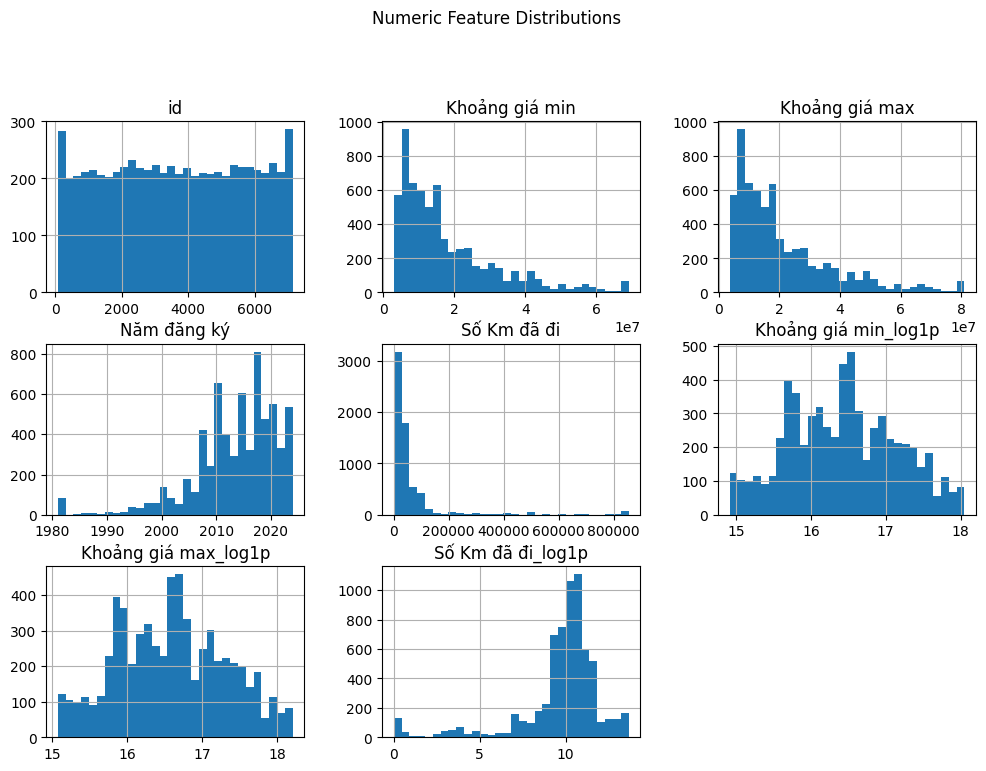

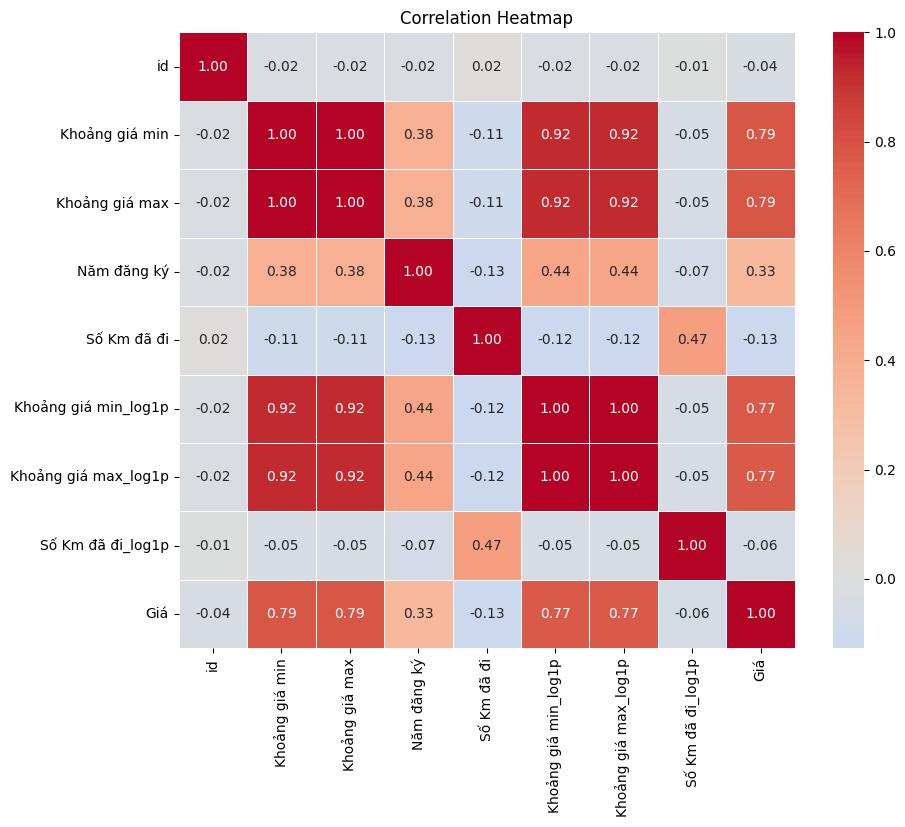

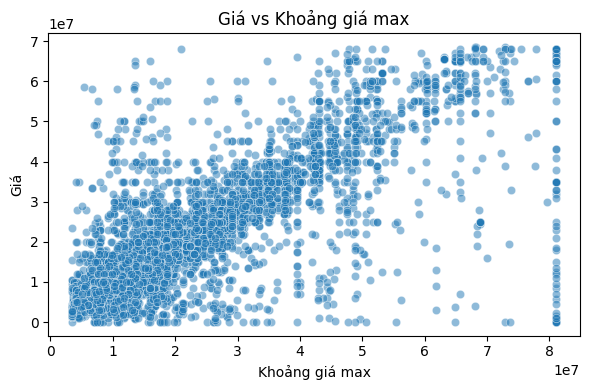

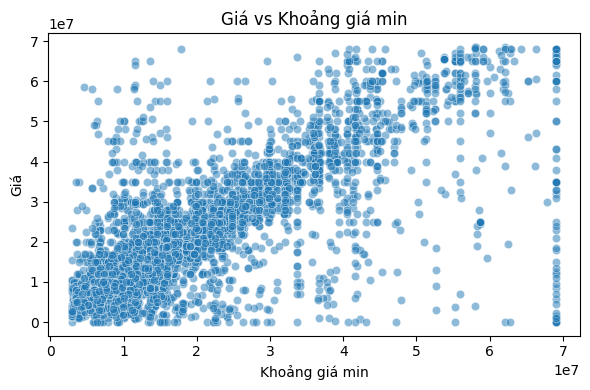

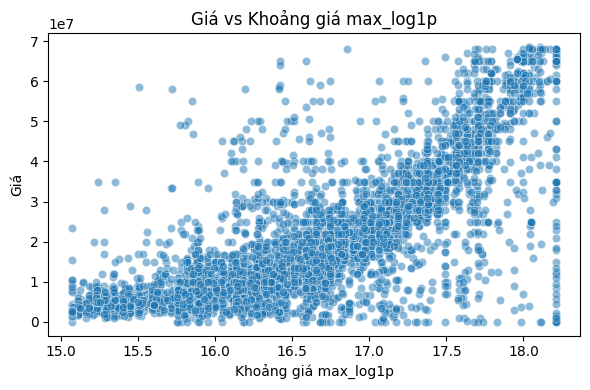

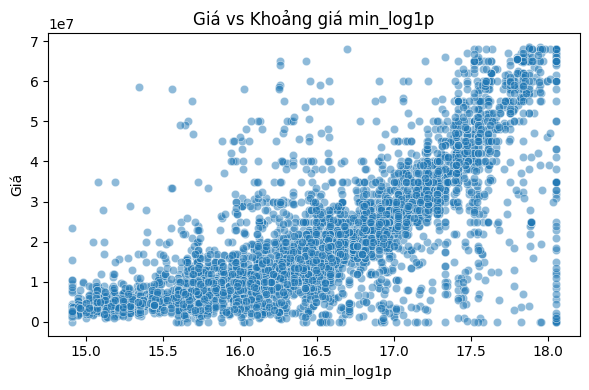

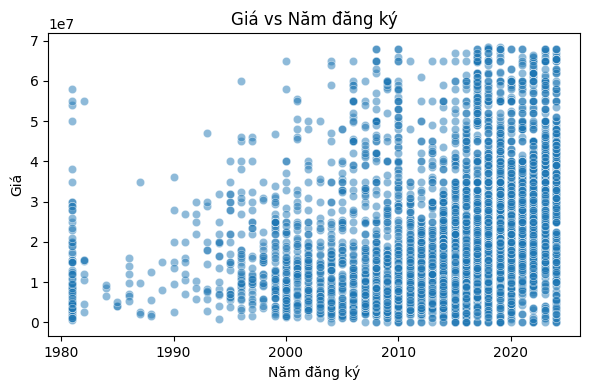

In [9]:
# =========================
# 4) Visualization
# =========================
import matplotlib.pyplot as plt
import seaborn as sns

# Histograms for numeric features
num_to_plot = selected_num_cols[:20]
if num_to_plot:
    df_clean[num_to_plot].hist(figsize=(12, 8), bins=30)
    plt.suptitle("Numeric Feature Distributions", y=1.02)
    plt.show()

# Correlation heatmap (numeric only)
if len(selected_num_cols) > 1:
    corr = df_clean[selected_num_cols + [TARGET_COL]].corr(numeric_only=True)
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, cmap="coolwarm", center=0, annot=True, fmt=".2f",linewidths=0.5,square=True)
    plt.title("Correlation Heatmap")
    plt.show()

# Target vs top correlated features
corrs = df_clean[selected_num_cols].corrwith(df_clean[TARGET_COL]).abs().sort_values(ascending=False)
top_feats = corrs.head(5).index.tolist()
for c in top_feats:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=df_clean[c], y=df_clean[TARGET_COL], alpha=0.5)
    plt.title(f"{TARGET_COL} vs {c}")
    plt.tight_layout()
    plt.show()


## 5) Feature Engineering

In [28]:
import scipy.stats as stats
# Giả sử df_clean là dataframe sau xử lý
categorical_cols = ['Thương hiệu', 'Loại xe', 'Dung tích xe', 'Dòng xe','Xuất xứ']

for col in categorical_cols:
    groups = [group["Giá"].dropna() for name, group in df_clean.groupby(col)]
    f_stat, p_val = stats.f_oneway(*groups)
    print(f"{col}: F-statistic = {f_stat:.2f}, p-value = {p_val:.5f}")

Thương hiệu: F-statistic = 18.62, p-value = 0.00000
Loại xe: F-statistic = 271.33, p-value = 0.00000
Dung tích xe: F-statistic = 58.92, p-value = 0.00000
Dòng xe: F-statistic = 36.97, p-value = 0.00000
Xuất xứ: F-statistic = 67.54, p-value = 0.00000


In [29]:
df_fe = df_clean.copy()


## 6) Modeling — Price Prediction

In [38]:
df_model = df_fe.copy()



target = 'Giá'

# Thêm các numeric features có tương quan cao
numeric_features = ["Năm đăng ký", "Số Km đã đi"]

categorical_features = ['Thương hiệu', 'Loại xe', 'Dung tích xe', 'Dòng xe','Xuất xứ']


# Tách X (input) và y (output)
X = df_model[categorical_features + numeric_features]
y = df_model[target]

print("Columns in X:", X.columns.tolist())
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Columns in X: ['Thương hiệu', 'Loại xe', 'Dung tích xe', 'Dòng xe', 'Xuất xứ', 'Năm đăng ký', 'Số Km đã đi']
Shape of X: (6546, 7)
Shape of y: (6546,)


In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# =============================
# 1. Chuẩn bị dữ liệu
# =============================
df_model = df_fe.copy()

# Tách target
target = "Giá"

# Các numeric features
numeric_features = [ "Năm đăng ký", "Số Km đã đi"]

# Các categorical features (để OneHotEncoder xử lý thay cho get_dummies)
categorical_cols = ['Thương hiệu', 'Loại xe', 'Dung tích xe', 'Dòng xe','Xuất xứ']

# X và y
X = df_model[categorical_features + numeric_features]
y = df_model[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

In [45]:
# =============================
# 2. BUILD PIPELINE
# =============================

# Numeric pipeline: impute median
numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

# Categorical pipeline: impute + one-hot
categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, numeric_features),
        ("cat", categorical_pipeline, categorical_features)
    ]
)

# Final model: Gradient Boosting Regressor
gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

# Combine thành 1 pipeline duy nhất
pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", gbr)
])

In [46]:
# =============================
# 3. TRAIN PIPELINE
# =============================
pipeline.fit(X_train, y_train)

# Predict test
y_pred = pipeline.predict(X_test)

# =============================
# 4. EVALUATION
# =============================
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Gradient Boosting Pipeline Results:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2 : {r2:.2f}")

Gradient Boosting Pipeline Results:
RMSE: 8857509.79
MAE: 5511108.91
R2 : 0.66


In [47]:
# =============================
# 5. SAVE PIPELINE TO 1 FILE
# =============================
joblib.dump(pipeline, "car_price_gbr_pipeline.pkl")
print("✅ Saved model to car_price_gbr_pipeline.pkl")

✅ Saved model to car_price_gbr_pipeline.pkl


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer # Import SimpleImputer
import joblib
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Impute missing values before training models
# Use median strategy for numerical features, as mean can be sensitive to outliers
imputer = SimpleImputer(strategy='median')

# Fit on X_train and transform both X_train and X_test
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)


ValueError: Cannot use median strategy with non-numeric data:
could not convert string to float: '100 - 175 cc'

In [ ]:
# --- Model 1: Linear Regression ---
# Khởi tạo model
lr_model = LinearRegression()

# Train model trên train set
lr_model.fit(X_train, y_train)

# Predict trên test set
y_pred_lr = lr_model.predict(X_test)

# Đánh giá performance
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))  # RMSE: Lỗi trung bình sqrt (thấp tốt)
mae_lr = mean_absolute_error(y_test, y_pred_lr)  # MAE: Lỗi tuyệt đối trung bình
r2_lr = r2_score(y_test, y_pred_lr)  # R2: Độ giải thích variance (gần 1 tốt)

# In kết quả
print("Linear Regression Results:")
print(f"RMSE: {rmse_lr:.2f}")
print(f"MAE: {mae_lr:.2f}")
print(f"R2: {r2_lr:.2f}")


In [ ]:
# --- Model 2: Random Forest Regressor ---
# Khởi tạo model (n_estimators=100: Số trees, tăng nếu cần accuracy nhưng chậm hơn)
rf_model = RandomForestRegressor(n_estimators=200, max_depth=None, random_state=42,)

# Train model trên train set
rf_model.fit(X_train, y_train)

# Predict trên test set
y_pred_rf = rf_model.predict(X_test)

# Đánh giá performance (giống Linear)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# In kết quả
print("\nRandom Forest Results:")
print(f"RMSE: {rmse_rf:.2f}")
print(f"MAE: {mae_rf:.2f}")
print(f"R2: {r2_rf:.2f}")


In [ ]:
# --- Model 3: Gradient Boosting Regressor ---
from sklearn.ensemble import GradientBoostingRegressor

# Khởi tạo model (n_estimators: số cây, learning_rate: tốc độ học)
gbr_model = GradientBoostingRegressor(
    n_estimators=300,     # số lượng cây boosting
    learning_rate=0.05,   # tốc độ học nhỏ giúp giảm overfitting
    max_depth=5,          # độ sâu cây con
    random_state=42
)

# Train model
gbr_model.fit(X_train, y_train)

# Predict trên test set
y_pred_gbr = gbr_model.predict(X_test)

# Đánh giá
rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

print("Gradient Boosting Regressor Results:")
print(f"RMSE: {rmse_gbr:.2f}")
print(f"MAE: {mae_gbr:.2f}")
print(f"R2: {r2_gbr:.2f}")


In [ ]:
# --- Model 4: XGBoost Regressor ---
from xgboost import XGBRegressor

# Khởi tạo model
xgb_model = XGBRegressor(
    n_estimators=500,         # số cây boosting
    learning_rate=0.05,       # tốc độ học
    max_depth=6,              # độ sâu mỗi cây
    subsample=0.8,            # sampling để tránh overfitting
    colsample_bytree=0.8,     # sampling theo feature
    random_state=42,
    n_jobs=-1
)

# Train model
xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)

# Đánh giá
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost Regressor Results:")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"MAE: {mae_xgb:.2f}")
print(f"R2: {r2_xgb:.2f}")


## 7) Modeling — Anomaly Detection

In [ ]:
# Model 1: Dựa trên Residual (phần dư của mô hình giá)
# Giả sử df_pred có 2 cột: 'Giá' và 'pred_price' (từ mô hình trước)
df_pred = df_fe.copy()
df_pred['pred_price'] = xgb_model.predict(X)  # dùng XGBoost model

# 1. Tính residual (phần dư)
df_pred['residual'] = df_pred['Giá'] - df_pred['pred_price']

# 2. Chuẩn hoá residual theo z-score (toàn bộ hoặc theo từng loại xe)
df_pred['z_resid'] = stats.zscore(df_pred['residual'])

# 3. Đánh dấu bất thường
df_pred['anomaly_resid'] = df_pred['z_resid'].apply(lambda z: 'Bất thường' if abs(z) > 2 else 'Bình thường')

# 4. Thống kê nhanh
print(df_pred['anomaly_resid'].value_counts())
print(df_pred[['Giá', 'pred_price', 'residual', 'z_resid', 'anomaly_resid']].head())

In [ ]:
# Model 2: Unsupervised — Isolation Forest
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

df_IF = df_pred.copy()

# 1. Chọn các đặc trưng quan trọng
features = [
    col for col in df_fe.columns
    if col.startswith(('Brand_', 'Model_', 'Type_', 'Xuất xứ_', 'Dung tích xe_'))
] + ['residual', 'z_resid']

X_iso = df_IF[features].fillna(0)

# 2. Chuẩn hoá dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_iso)

# 3. Khởi tạo Isolation Forest
iso = IsolationForest(contamination=0.05, random_state=42, n_jobs=-1)
df_IF['anomaly_iso'] = iso.fit_predict(X_scaled)
df_IF['iso_score'] = iso.decision_function(X_scaled)  # Score âm → bất thường hơn

# 4. Chuyển nhãn
df_IF['anomaly_iso'] = df_IF['anomaly_iso'].map({1: 'Bình thường', -1: 'Bất thường'})

# 5. Thống kê kết quả
print("Phân bố kết quả từ Isolation Forest:")
print(df_IF['anomaly_iso'].value_counts())

# 6. Hiển thị Top 10 xe bất thường nhất (score âm nhỏ nhất)
anomalies_iso = df_IF[df_IF['anomaly_iso'] == 'Bất thường'][[
    'Giá', 'pred_price', 'residual', 'z_resid', 'iso_score', 'anomaly_iso'
]].sort_values(by='iso_score').head(10)

print("\nTop 10 xe bất thường theo Isolation Forest:")
display(anomalies_iso)


In [ ]:
# Model 3: Unsupervised — Local Outlier Factor (LOF)
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler

# Tạo bản sao từ df_pred (đã có residual và z_resid)
df_LOF = df_pred.copy()
# 1. Chọn các đặc trưng quan trọng
features = [
    col for col in df_fe.columns
    if col.startswith(('Brand_', 'Model_', 'Type_', 'Xuất xứ_', 'Dung tích xe_'))
] + ['residual', 'z_resid']

X_lof = df_LOF[features].fillna(0)

# 2. Chuẩn hoá dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_lof)

# 3. Khởi tạo & fit Local Outlier Factor
# n_neighbors=20 → số lượng điểm lân cận để so sánh mật độ
lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=0.05,  # tỷ lệ điểm bất thường mong đợi
    novelty=False,       # False = chỉ fit & predict trên cùng dữ liệu
    n_jobs=-1
)

# 4. Fit & lấy nhãn
df_LOF['anomaly_lof'] = lof.fit_predict(X_scaled)
df_LOF['lof_score'] = lof.negative_outlier_factor_

# 5. Chuyển nhãn (1 → bình thường, -1 → bất thường)
df_LOF['anomaly_lof'] = df_LOF['anomaly_lof'].map({1: 'Bình thường', -1: 'Bất thường'})

# 6. Thống kê kết quả
print("Phân bố kết quả từ Local Outlier Factor:")
print(df_LOF['anomaly_lof'].value_counts())

# 7. Xem 10 xe bất thường nhất
anomalies_lof = df_LOF[df_LOF['anomaly_lof'] == 'Bất thường'][[
    'Giá', 'pred_price', 'residual', 'z_resid', 'lof_score', 'anomaly_lof'
]].sort_values(by='lof_score').head(10)

print("\nTop 10 xe bất thường theo LOF:")
display(anomalies_lof)